I wanna make a ML model to detect tuberculosis because fuck tuberculosis. Wish me luck

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

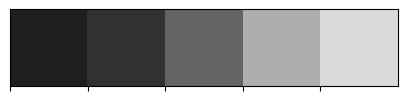

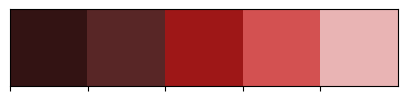

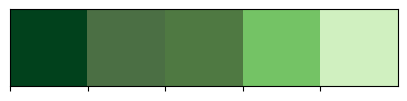

In [21]:

colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_red)
sns.palplot(colors_green)

In [22]:
labels = ['Normal', 'Tuberculosis']

In [23]:
X_train = []
Y_train = []
image_size = 200



for i in labels:
  folder_path = os.path.join('/content/drive/MyDrive/Colab Notebooks/tuberculosis_detection/Data', i)
  for j in tqdm(os.listdir(folder_path)):
    image_name = os.path.join(folder_path, j)
    img = cv2.imread(image_name)
    img = cv2.resize(img, (image_size, image_size))

    X_train.append(img)
    Y_train.append(i)



X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 700/700 [00:08<00:00, 82.73it/s] 


In [24]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=1312)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = 0.1, random_state = 1312)


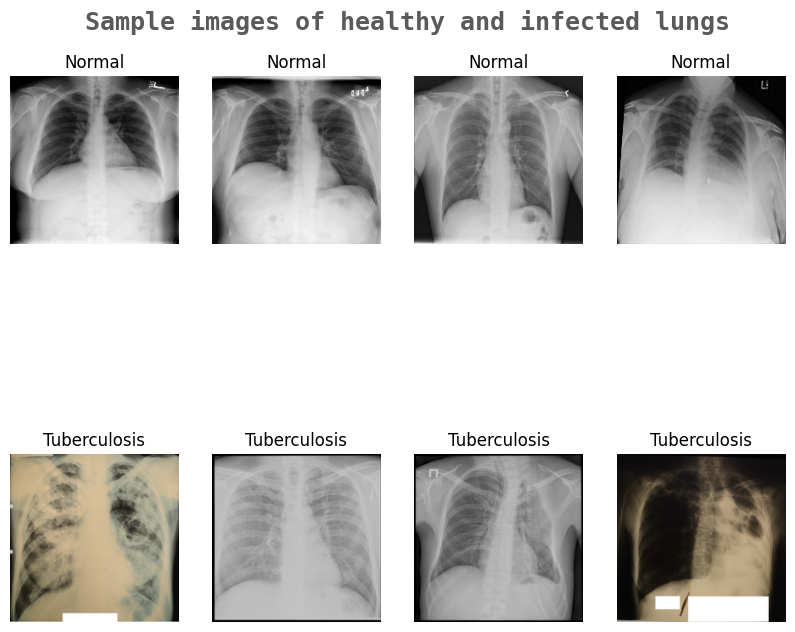

In [25]:
k = 0
fig, ax = plt.subplots(2,4, figsize = (10, 9))
fig.text(s='Sample images of healthy and infected lungs',
         size=18, fontweight = 'bold', fontname = 'monospace',
         color = colors_dark[1], y = 0.85, x= 0.2, alpha = 0.8)

for i in labels:
  m = 0
  j = 0
  while (j < 4):
    if Y_train[m] == i:
      ax[labels.index(i), j].axis('off')
      ax[labels.index(i), j].imshow(X_train[m])
      ax[labels.index(i), j].set_title(Y_train[m])
      j += 1
    m += 1





In [29]:
Y_train_new = []

for i in Y_train:
  Y_train_new.append(labels.index(i))
Y_train = Y_train_new
Y_train = tf.keras.utils.to_categorical(Y_train)


Y_test_new = []

for i in Y_test:
  Y_test_new.append(labels.index(i))
Y_test = Y_test_new
Y_test = tf.keras.utils.to_categorical(Y_test)



[1. 0.]


In [34]:
effnet = EfficientNetB0(weights = 'imagenet', include_top = False, input_shape = (image_size, image_size, 3))

16705208/16705208 [==============================] - 0s 0us/step


In [35]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate = 0.5)(model)
model = tf.keras.layers.Dense(2, activation= 'softmax')(model)
model = tf.keras.models.Model(inputs = effnet.input, outputs = model)




In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 200, 200, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 200, 200, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 200, 200, 3)          0         ['normalization[0][0]']   

In [40]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'] )

In [41]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("tb_detect.h5", monitor = 'val_accuracy', save_best_only = True, mode = 'auto', verbose = 1)
reduce_lr = ReduceLROnPlateau( monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001, mode = 'auto', verbose = 1)

In [42]:
history = model.fit(X_train, Y_train, validation_split = 0.1, epochs = 10, verbose = 1,
                    batch_size = 32, callbacks = [tensorboard, checkpoint, reduce_lr])

Epoch 1/10
107/107 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9806
Epoch 1: val_accuracy improved from -inf to 0.99206, saving model to tb_detect.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


107/107 [==============================] - 78s 272ms/step - loss: 0.0455 - accuracy: 0.9806 - val_loss: 0.0318 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 2/10
107/107 [==============================] - ETA: 0s - loss: 0.0224 - accuracy: 0.9924
Epoch 2: val_accuracy improved from 0.99206 to 1.00000, saving model to tb_detect.h5
107/107 [==============================] - 26s 239ms/step - loss: 0.0224 - accuracy: 0.9924 - val_loss: 0.0064 - val_accuracy: 1.0000 - lr: 0.0010
Epoch 3/10
107/107 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9979
Epoch 3: val_accuracy did not improve from 1.00000
107/107 [==============================] - 24s 228ms/step - loss: 0.0051 - accuracy: 0.9979 - val_loss: 0.0076 - val_accuracy: 0.9974 - lr: 0.0010
Epoch 4/10
107/107 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9979
Epoch 4: val_accuracy did not improve from 1.00000

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
107/107